In [1]:
cd /usr/users/ga004/buntingd/FP_dev/data/0.3/Callset/2013

/usr/users/ga004/buntingd/FP_dev/data/0.3/Callset/2013


In [2]:
import vcfnp
import numpy as np
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt

import allel
import seaborn as sns
import pandas as pd

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score,calinski_harabaz_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

%matplotlib inline
sns.set_style('whitegrid')
mpl.rcParams['figure.figsize'] = (10, 6)


In [3]:
def compute_bic_adegenet(km,X):
    #number of clusters
    k = km.n_clusters
    #size of data set
    N, d = X.shape

    WSS = sum([np.sum((km.cluster_centers_[i] - X[km.predict(X)==i,:])**2 )
                    for i in range(km.n_clusters)])

    return(N*np.log(WSS/N) + k*np.log(N))

def plot_ld(gn, title):
    m = allel.stats.rogers_huff_r(gn) ** 2
    ax = allel.plot.pairwise_ld(m)
    ax.set_title(title)
    return m

# Loading 2013 Biallelic SNPs

In [4]:
callset = h5py.File('2013_SNPs_syn.hd5', mode='r')
genotypes = allel.GenotypeChunkedArray(callset['calldata']['GT'])
variants = allel.VariantChunkedTable(callset['variants'])
samples = list(callset['samples'])

# Filter Sites and Individuals


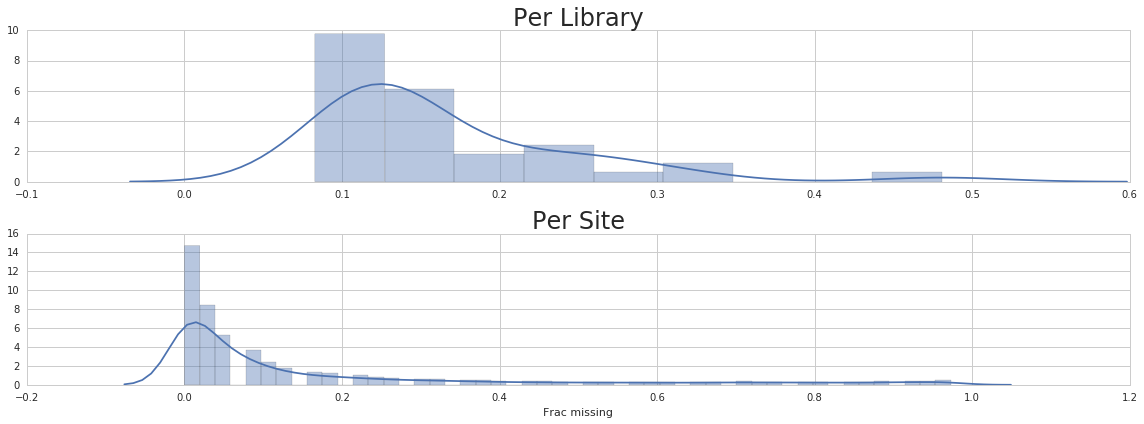

In [5]:
plt.figure(figsize=(16, 6))
sns.distplot(genotypes.count_missing(axis=0)[:]/len(variants), ax=plt.subplot(211))
sns.distplot(genotypes.count_missing(axis=1)[:]/len(samples), ax=plt.subplot(212))

plt.subplot(212).set_xlabel("Frac missing")
plt.subplot(212).set_title("Per Site", fontsize=24)
plt.subplot(211).set_title("Per Library", fontsize=24)

plt.tight_layout()

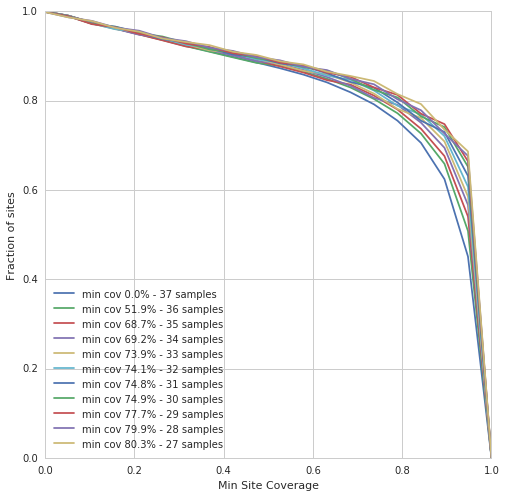

In [6]:
X = np.linspace(0., 1, 20)
plt.figure(figsize=(8,8))

sample_missing = genotypes.count_missing(axis=0)[:] / len(variants)
for s in [1] + sorted(sample_missing)[::-1][:10]:
    indvs = sample_missing < s
    if indvs.sum() == 0:
        continue
    ind_filtered = genotypes[:,indvs]
    site_missing = ind_filtered.count_missing(axis=1)[:]/ind_filtered.shape[1]
    plt.plot(1-X, [np.mean(site_missing < x) for x in X], 
             label="min cov {0:.1%} - {1} samples".format(1-s, indvs.sum()))
    
plt.legend(loc='best')
plt.xlabel("Min Site Coverage")
plt.ylabel("Fraction of sites")

## Require samples to have coverage on at least 40% of sites and each site to be covered in at least 80% of samples leaving 127,462 sites and 37 samples

In [7]:
filtered1 = genotypes[:,(genotypes.count_missing(axis=0)[:]/len(variants)) < 0.6]
filtered = filtered1[(filtered1.count_missing(axis=1)[:]/filtered1.shape[1]) < 0.2,:]
print(filtered.shape)
filtered

(65634, 37, 2)


<GenotypeArray shape=(65634, 37, 2) dtype=int8>
0/0 0/1 0/1 0/1 0/0 ... 0/0 0/0 0/0 0/1 0/1
0/0 0/1 0/1 0/1 0/0 ... 0/1 0/1 0/1 0/1 0/1
0/0 0/1 0/1 0/1 0/0 ... 0/1 0/1 ./. 0/1 0/1
...
0/1 0/1 0/1 0/1 0/0 ... 0/0 0/0 0/0 0/1 0/1
0/0 1/1 0/1 0/1 0/0 ... 1/1 1/1 1/1 0/1 1/1
0/0 0/0 0/0 0/0 0/0 ... 0/1 0/1 0/1 0/0 0/0

In [8]:
n_alt = allel.AlleleCountsChunkedArray(filtered.to_n_alt(fill=-1))
n_alt = np.where(n_alt == -1, np.array([float('nan')]),n_alt)
n_alt = np.where(np.isnan(n_alt), 
                 np.nanmean(n_alt, axis=1).reshape(-1,1), 
                 n_alt)

# Linkage Disequllibrium

In [9]:
#r = allel.rogers_huff_r(n_alt)

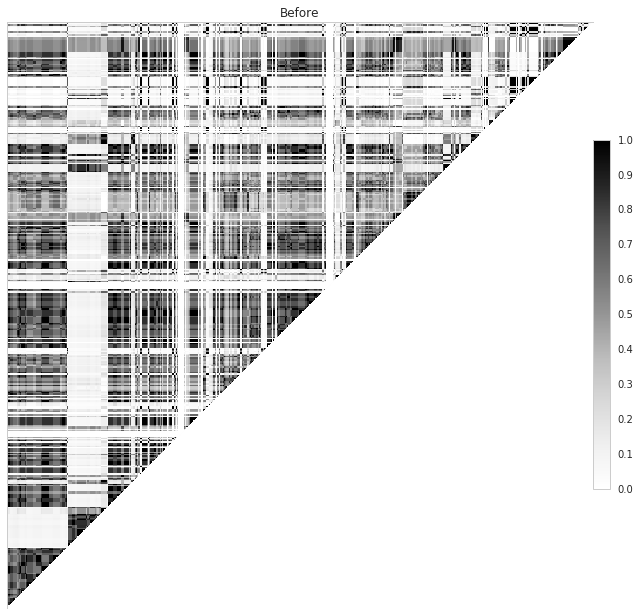

In [10]:
m = plot_ld(n_alt[:500], 'Before')

In [11]:
unlinked = n_alt[allel.locate_unlinked(n_alt),:]
print("Unlinking reduced the number of sites from {0} to {1}".format(filtered.shape[0], unlinked.shape[0]))

Unlinking reduced the number of sites from 65634 to 5296


array([ 0.0929032 ,  0.57471287,  0.25252524, ...,  0.02434078,
        0.07609991,  0.02434077], dtype=float32)

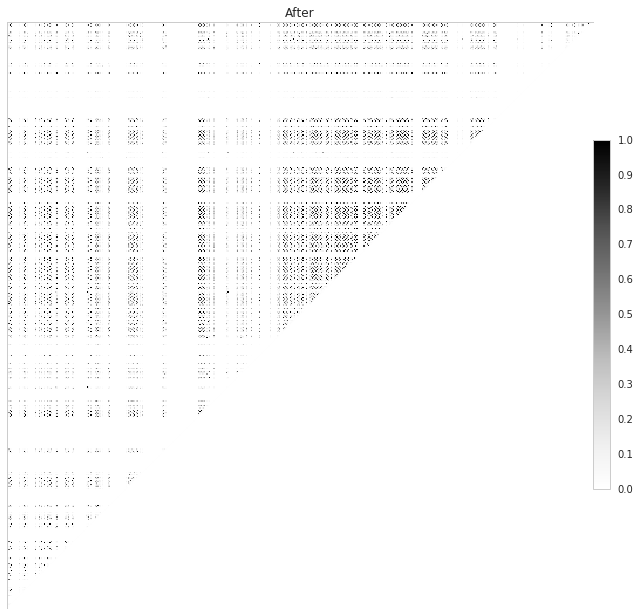

In [12]:
plot_ld(unlinked[:500], 'After')

# DAPC 

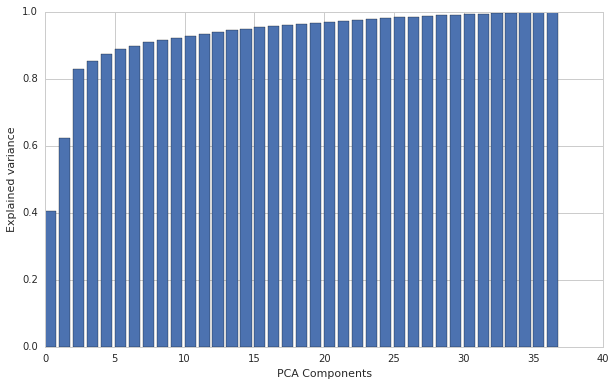

In [13]:
n_pca1 = n_alt.shape[1]
cluster_range = range(2, 25)
n_pca2 = 20
n_cluster = 4 

# Scale
X = scale(unlinked.T, with_std=False, with_mean=False)

#Permform PCA retaining all comps
pca = PCA(n_pca1)
Y = pca.fit_transform(X)
plt.bar(np.arange(n_pca1), np.cumsum(pca.explained_variance_ratio_))

plt.xlabel("PCA Components")
plt.ylabel("Explained variance")

In [14]:
# K-means clustering of the PCs
km_list = [KMeans(int(i), tol=1e-7, max_iter=1e5, n_init=100).fit(Y) for i in cluster_range]

# K selection metrics

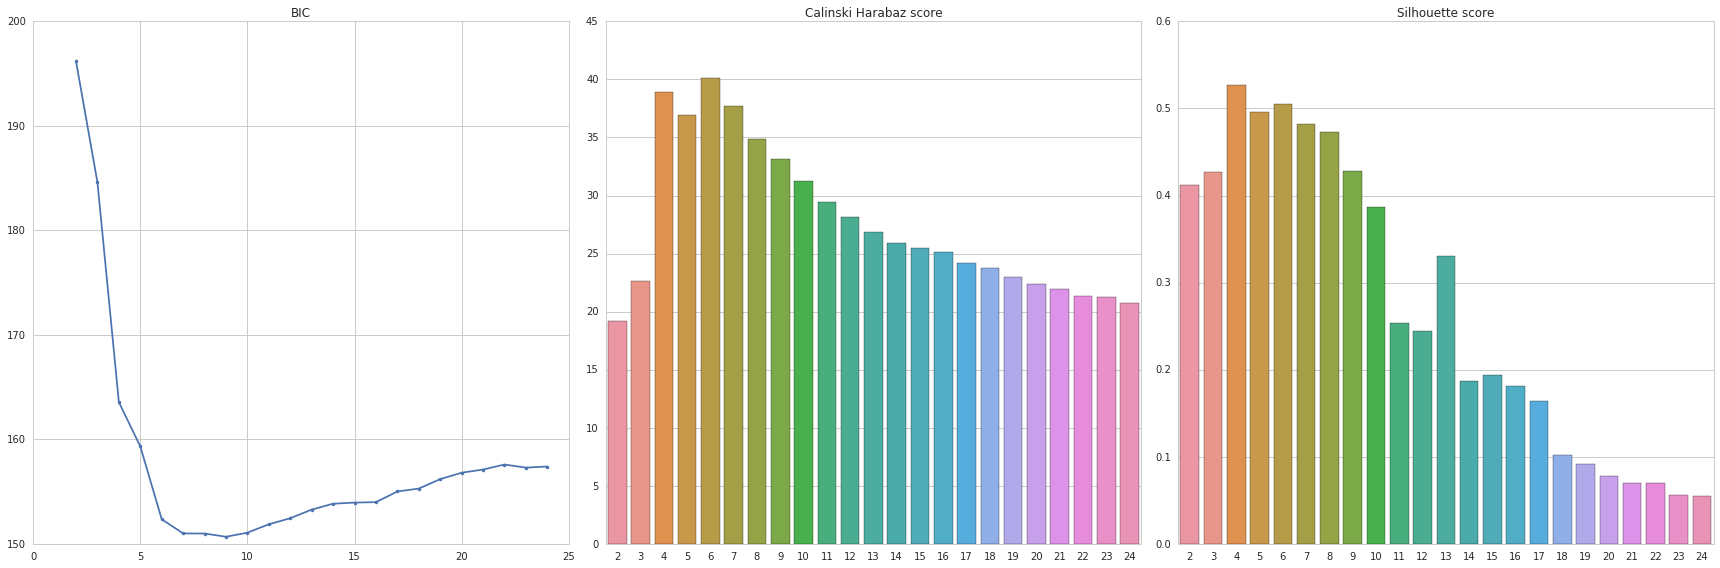

In [15]:
# Calinski Harabaz score
ch = [calinski_harabaz_score(Y,km.predict(Y)) for km in km_list]

# Silhouette Score
sil = [silhouette_score(Y,km.predict(Y)) for km in km_list]

# BIC
bic = [compute_bic_adegenet(km,Y) for km in km_list]

plt.figure(figsize=(24, 8))
plt.subplot(131).plot(list(cluster_range), bic, '.-')
plt.subplot(131).set_title("BIC")

sns.barplot(list(cluster_range), ch, ax=plt.subplot(132))
plt.subplot(132).set_title("Calinski Harabaz score")
sns.barplot(list(cluster_range), sil, ax=plt.subplot(133))
plt.subplot(133).set_title("Silhouette score")

plt.tight_layout()

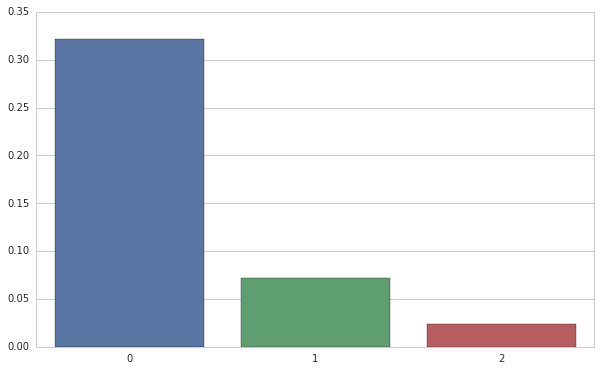

In [16]:
lda = LinearDiscriminantAnalysis(solver='eigen', tol=1e-17,  shrinkage='auto')

Z = PCA(n_pca2).fit_transform(X)
lda.fit(Z, km_list[2].predict(Y))

sns.barplot(list(range(len(lda.explained_variance_ratio_))), lda.explained_variance_ratio_**2)

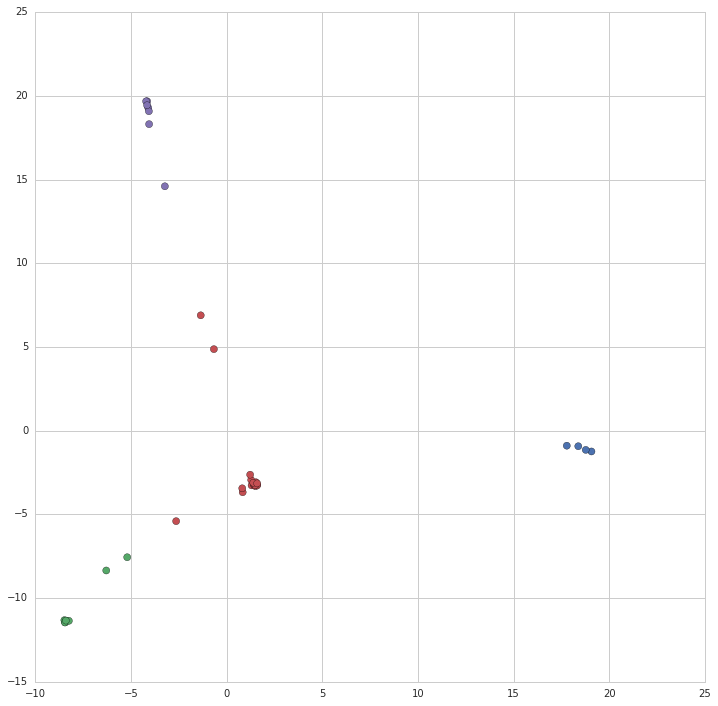

In [17]:
plt.figure(figsize=(12,12))
plt.scatter(x=lda.transform(Z)[:,0], y=lda.transform(Z)[:,1], c=[sns.color_palette(n_colors=6)[int(i)] for i in lda.predict(Z)],s=50,  marker='o')

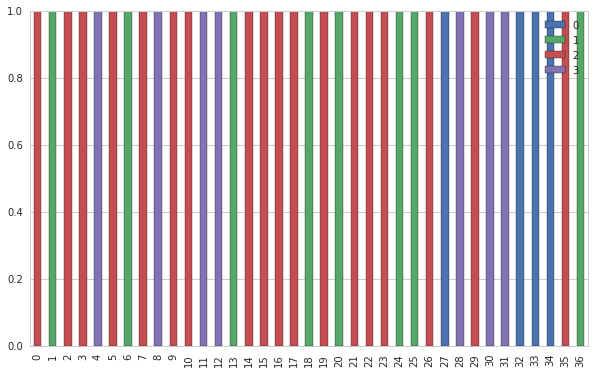

In [18]:
df = pd.DataFrame(lda.predict_proba(Z))
plt.gcf().set_size_inches(12, 4)
df.plot(kind='bar',stacked=True)

In [19]:
groups = pd.DataFrame(np.stack([samples, lda.predict_proba(Z).argmax(axis=1)]).T, columns=['samples', 'group'])

In [20]:
%load_ext rpy2.ipython
%R require(ggplot2)
%R require(ggtree)

/usr/users/ga004/buntingd/FP_dev/dev/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: ggplot2

  warnings.warn(x, RRuntimeWarning)
/usr/users/ga004/buntingd/FP_dev/dev/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: ggtree

  warnings.warn(x, RRuntimeWarning)
/usr/users/ga004/buntingd/FP_dev/dev/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: ggtree v1.6.11  For help: https://guangchuangyu.github.io/ggtree

If you use ggtree in published research, please cite:
Guangchuang Yu, David Smith, Huachen Zhu, Yi Guan, Tommy Tsan-Yuk Lam. ggtree: an R package for visualization and annotation of phylogenetic trees with their covariates and other associated data. Methods in Ecology and Evolution 2017, 8(1):28-36, doi:10.1111/2041-210X.12628

  warnings.warn(x, RRuntimeWarning)


array([1], dtype=int32)

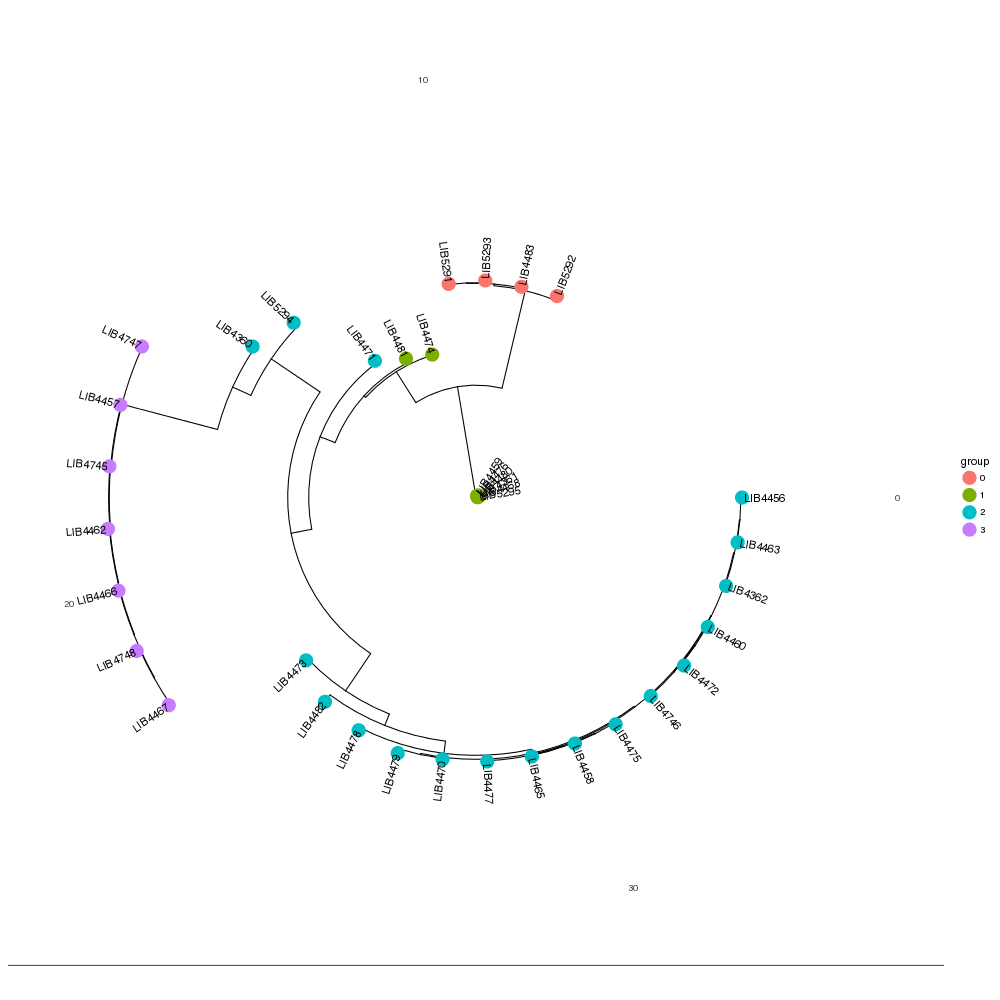

In [21]:
%%R -w1000 -h1000 -o svg -i groups

raxml1 <- read.raxml("/usr/users/ga004/buntingd/FP_dev/data/0.3/Tree/2013/comb/RAxML_bipartitionsBranchLabels.2013")
p <- ggtree(raxml1, layout="circular") 
p <- p %<+% groups 
p <- p + geom_tippoint(aes(color=group), size=6) 
p <- p + scale_colour_hue()
p <- p + theme_tree2(legend.position='right')
p <- p + geom_tiplab2(size=4) 
p

In [26]:
%%R -w1000 -h1000 -o svg -i groups

groups

   samples group
0  LIB4360     2
1  LIB4361     1
2  LIB4362     2
3  LIB4456     2
4  LIB4457     3
5  LIB4458     2
6  LIB4459     1
7  LIB4460     2
8  LIB4462     3
9  LIB4463     2
10 LIB4465     2
11 LIB4466     3
12 LIB4467     3
13 LIB4468     1
14 LIB4470     2
15 LIB4471     2
16 LIB4472     2
17 LIB4473     2
18 LIB4474     1
19 LIB4475     2
20 LIB4476     1
21 LIB4477     2
22 LIB4478     2
23 LIB4479     2
24 LIB4480     1
25 LIB4481     1
26 LIB4482     2
27 LIB4483     0
28 LIB4745     3
29 LIB4746     2
30 LIB4747     3
31 LIB4748     3
32 LIB5291     0
33 LIB5292     0
34 LIB5293     0
35 LIB5294     2
36 LIB5295     1


In [27]:
groups.dtypes

samples    object
group      object
dtype: object